In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Getting mock data for testing

In [2]:
df = pd.read_csv('/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/sim_pulse_01.txt', delimiter = '    ')
df.head()

,time_sec,intensity
0,0.000000,0.316162
1,0.003662,0.728027
2,0.007325,-0.100037
3,0.010987,0.090271
4,0.014649,0.344971


### Constant acceleration model eqn (1)

In [3]:
p0 = 0                     # rest phase phi 0 in eqn below
t = df['time_sec']        
w0 = 5
a = 5                      # acceleration parameter alpha in the eqn below

Equation 1 in K smith(2016). 
$$ \phi(t) = \phi_{0} + \omega_{0}t + \frac{1}{2}\alpha t^2$$

In [4]:
def pulse_phase(p0,t,w0,a):
    '''
    This function calculates and returns pulse phase at any given time 't' when acceleration 'a', intial 
    phase 'p0' and angular frequency 'w0' is known.
    '''
    phase = p0 + w0*t + 0.5*a*t**2
    return phase

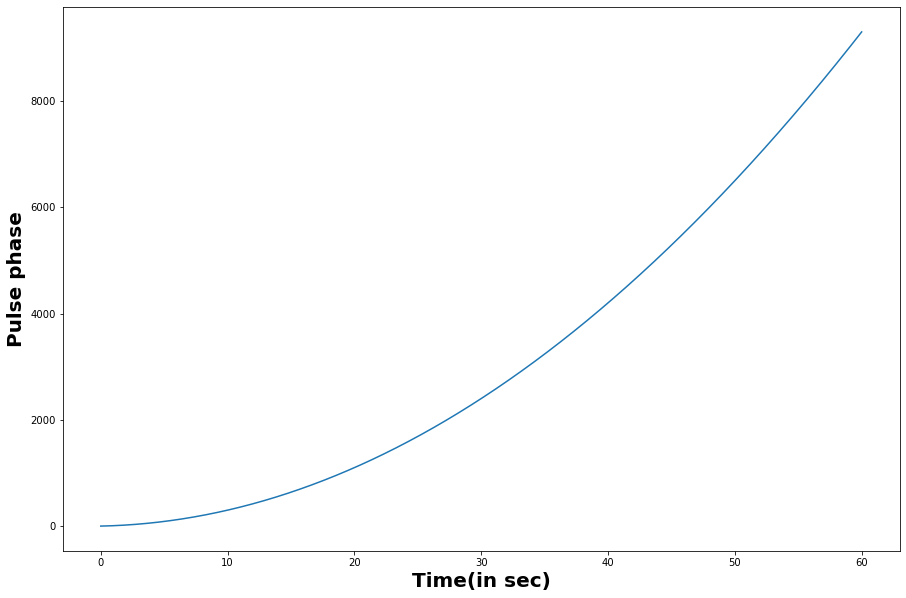

In [5]:
fig, pulse = plt.subplots(figsize = (15,10))
x1 = t
y1 = pulse_phase(p0,t,w0,a)
pulse.plot(x1,y1)
pulse.set_xlabel('Time(in sec)', fontsize = 20, weight = 'bold')
pulse.set_ylabel('Pulse phase', fontsize = 20, weight = 'bold')
plt.show()

### Von-Mises profile eqn (2)

Von Mises profile can be obtained from the euqtion(Eqn 2, K Smith)

$$ \rho(\phi) = e^{-2\kappa(sin^2(\phi/2))}$$

where $$\kappa = \frac{log(2)}{2sin^2{(\pi D/2)}}$$

In [6]:
phase_angle = pulse_phase(p0,t,w0,a)

def von_mises_profile(angle,duty):
    '''
    This function calculates von_mises profile based on duty cycle obtained from previous kappa function.
    For the vlue of pulse_phase it makes a call from pulse_phase function defined above
    '''
    k = (np.log(2))/(2*(np.sin((np.pi*duty)/2))**2)
    
    y = np.exp(-2*k*(np.sin(angle/2))**2)
    
    return y

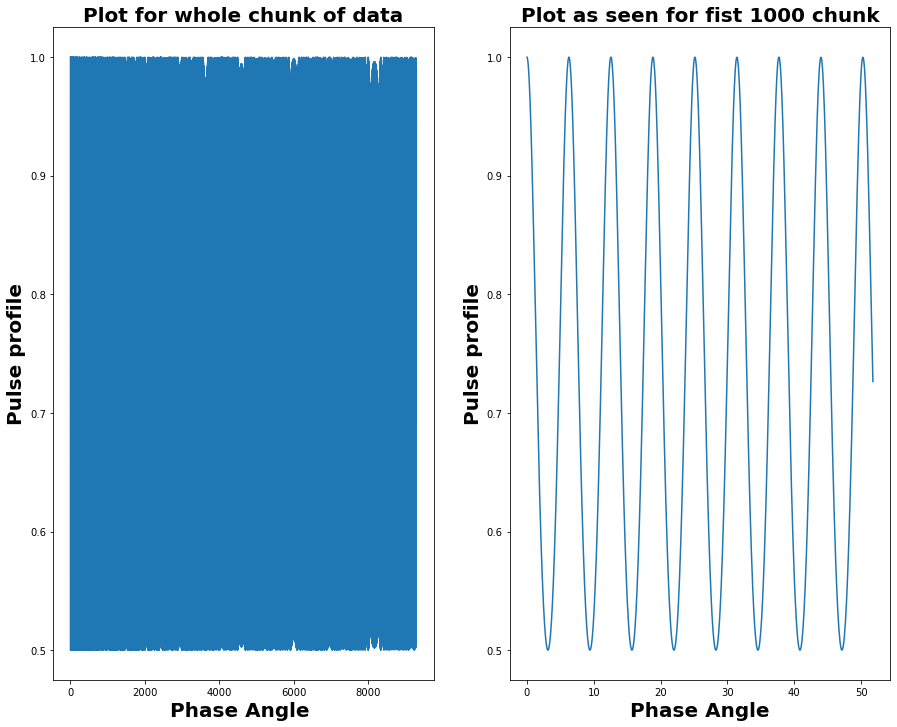

In [7]:
fig, von_mises = plt.subplots(nrows=1, ncols=2, figsize = (15,12))
x2 = phase_angle
y2 = von_mises_profile(x2, 5)
von_mises[0].plot(x2,y2)
von_mises[1].plot(x2[1:1000], y2[1:1000])
von_mises[0].set_xlabel('Phase Angle ', fontsize = 20, weight = 'bold')
von_mises[0].set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
von_mises[1].set_xlabel('Phase Angle', fontsize = 20, weight = 'bold')
von_mises[1].set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
von_mises[0].set_title('Plot for whole chunk of data', fontsize = 20, weight = 'bold')
von_mises[1].set_title('Plot as seen for fist 1000 chunk',fontsize = 20, weight = 'bold')
plt.savefig('/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/Pulse_profile.pdf')
plt.show()


### Detection statistic (5)

Intensity time stream $I(t) = \rho(\phi(t))$. So, ignoring the downsampling for now, we just take intensity time stream to be values calculated from von-mises funtion above. But we use normalization condition to find '$\eta$' (noize parameter) using the equation(eqn 4 in Smith K) below.

$$ \eta^{-2} t_{s} \sum_{k=0}^{N-1} (I_{k})^2 = 1$$ 

So rearranging we get,
$$ \eta^{-2} = \frac{1}{t_{s} \sum_{k=0}^{N-1}(I_{k})^2} $$

We can use this to find the detection statistic using equation below. 

$$ \hat{\epsilon} = \eta^{-2} t_{s} \sum_{k=0}^{N-1} d_{k}I_{k} $$

In [8]:
sample_time = 0.005  # taken to be the time resolution we used 
eta_negativesquared = 1/(sample_time*np.sum((von_mises_profile(x2, 5))**2)) # Used normalization eqn(4)

def detection_statistic(dk, ik):
    '''
    This function calculates the detection statistic (eqn 5, K smith). Function arguments dk and ik are data 
    timestream and intensity timestream that we suuply as lists.d_k is intensity data in the table above and 
    I_k is von_mises profile calculated for various phase angle. Phase angle itself if calculated from pulse_
    phase function for the time series. This furnction returns detection statistic value as an output.
    '''
    sum_dk_ik =  0
    for i1 in np.arange(len(df['time_sec'])):
        val1 = dk[i1]*ik[i1]
        sum_dk_ik +=val1
        
    det_stat = sample_time*eta_negativesquared*sum_dk_ik
    return det_stat


In [9]:
detection_statistic(df['intensity'], y2)

0.4075857447703745